In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

--2023-11-21 20:23:35--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21013 (21K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]  20.52K  --.-KB/s    in 0.001s  

2023-11-21 20:23:35 (27.3 MB/s) - ‘models.py’ saved [21013/21013]

--2023-11-21 20:23:35--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7280 (7.1K) [text/plain]
Savi

In [4]:
from utils import vision
from utils import utils
from utils import losses

In [5]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'CPU', 'GPU' or 'TPU'

    'IMAGE_SIZE': (256, 256),
    'INPUT_SHAPE': (256, 256, 3),
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation

    'BACKBONE': 'custom',        # 'custom', 'VGG16', 'VGG19' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 16,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 250,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-4,

    'RECONS_LOSS': 'PERCEPTUAL',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [5,8,13,18],    # [5,8,13,18], None
    'PERCEP_LOSS_MODEL': 'VGG19', # custom', 'VGG16', 'VGG19' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    'SAVE_WEIGHTS_PER_EPOCH': 10,
    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "attention_resnet50_autoencoder_model/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "attention_resnet50_autoencoder_model/BD67_dataset/images",
}

In [6]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'
TFRECORD_TRAIN_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images.tfrecords'
TFRECORD_TEST_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images_test.tfrecords'
BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/partitioned/grid_0')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images/partitioned/grid_0')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front/partitioned/grid_0')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')
REFERENCE_BD67_NORMAL_FRONT = os.path.join(DATASET_PATH, 'defect_free/Front/reference_img')

In [7]:
img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_PATH, 'png')
rotated_img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_ROTATED_PATH, 'png')
all_img_files = img_files + rotated_img_files
reference_img_file = utils.get_image_file_list(REFERENCE_BD67_NORMAL_FRONT, 'png')

print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all image files: ", len(all_img_files))
print("Number of reference image files: ", len(reference_img_file))

Number of flat image files:  110
Number of rotated image files:  108
Number of all image files:  218
Number of reference image files:  1


In [8]:
# Shows image samples from dataset
def show_image_samples_from_batch(img_files, grid=(3,3), figsize=(10, 10)):
    image_batch = utils.load_and_prepare_images(img_files, scl=True)

    fig = plt.figure(figsize=figsize)

    for index, image in enumerate(image_batch):  # Get first batch
      plt.subplot(grid[0], grid[1], index + 1)
      plt.imshow(image[:, :, :])
      plt.axis('off')
      if index >= (len(image_batch)-1):
        break

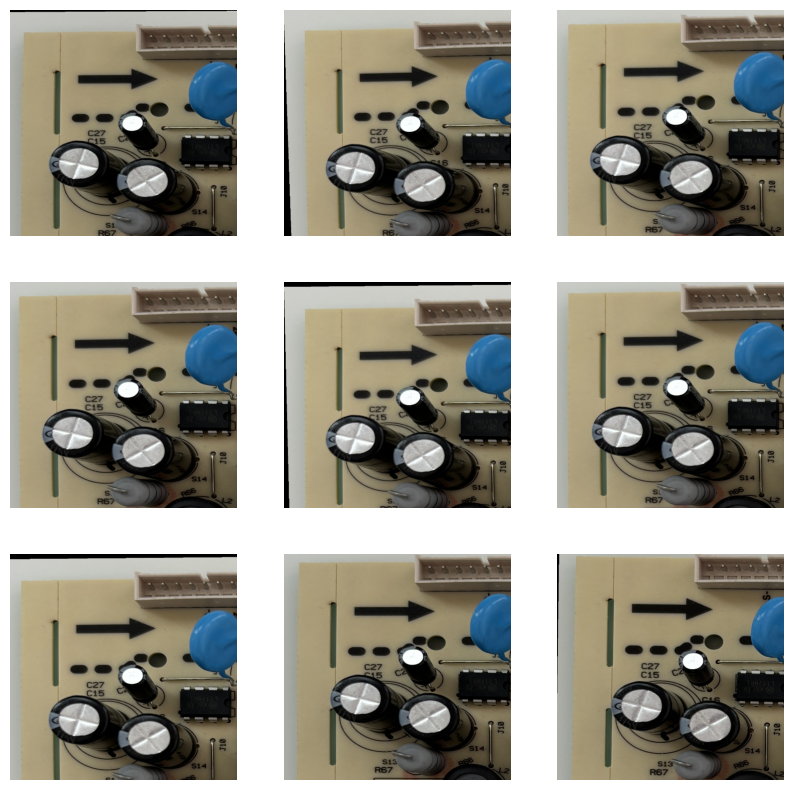

In [9]:
show_image_samples_from_batch(all_img_files[:9])

In [10]:
train_dataset = utils.create_dataset_pipeline(all_img_files, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0, duplicate=False, aug_layer=None, data_aug_power=1, accelerator='GPU')

In [11]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [12]:
print("Number of batches to be trained: ", len(train_dataset))

Number of batches to be trained:  14


In [13]:
class AttentionResNet50EncoderModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """
    def __init__(self, input_shape, latent_dim, layer_sizes=None, mse_lambda=1.0):
        super(AttentionResNet50EncoderModel, self).__init__()
        self._input_shape = input_shape
        assert (input_shape[0] > 224) and (input_shape[1] > 224)  # Input minimum shape (224, 224)
        self._latent_dim = latent_dim
        self._mse_lambda = mse_lambda

        self._layer_iter = 0
        self._layer_sizes = [32, 64, 128, 128, 256, 256, 256]
        if layer_sizes != None:
          self._layer_sizes = layer_sizes
        num_strides = len(self._layer_sizes)
        self._num_dense = int(self._input_shape[0]/(2**num_strides))

        self.config_conv_blocks()

        self._attention_resnet50_encoder_network = self.build_attention_resnet50_encoder_network()
        self._decoder_network = self.build_decoder_network()
        self._attention_resnet50_autoencoder_model = self.build_attention_resnet50_autoencoder_model()

        self._loss_tracker = tf.keras.metrics.Mean(name="loss")
        self._mae_loss = tf.keras.metrics.MeanAbsoluteError()

    def call(self, inputs):
        return self._attention_resnet50_autoencoder_model(inputs, training=False)

    def compile(self, model_optimizer):
        super(AttentionResNet50EncoderModel, self).compile()
        self._model_optimizer = model_optimizer

    def config_conv_blocks(self, padding='same', use_bias=True, batch_norm=True, use_leaky_relu=True, leaky_slope=0.2):
        self.padding = padding
        self.use_bias = use_bias
        self.batch_norm = batch_norm
        self.leaky_slope = leaky_slope
        self.act_func = tf.keras.layers.LeakyReLU(self.leaky_slope) if use_leaky_relu else tf.keras.layers.ReLU()

    def conv_block(self, x, filters, kernel, stride, deconv=False, name='conv_block'):
        if deconv:
          x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=(kernel,kernel), strides=stride, padding=self.padding, use_bias=self.use_bias, name=name)(x)
        else:
          x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(kernel,kernel), strides=stride, padding=self.padding, use_bias=self.use_bias, name=name)(x)

        if self.batch_norm:
          name = 'conv_block_bacth_norm_' + str(self._layer_iter)
          x = keras.layers.BatchNormalization(name=name)(x)

        self._layer_iter += 1
        x = self.act_func(x)
        return x

    def summary(self):
        return self._attention_resnet50_autoencoder_model.summary()

    def build_decoder_network(self):
        input = keras.Input(shape=self._latent_dim)
        # Decoder Part
        x = keras.layers.Dense(units=(self._num_dense*self._num_dense*self._layer_sizes[-2]))(input)
        #x = BatchNormalization(name='batch_norm_2')(x)
        x = keras.layers.LeakyReLU(alpha=self.leaky_slope)(x)

        x = keras.layers.Reshape((self._num_dense,self._num_dense, self._layer_sizes[-2]), name='reshape_latent')(x)

        # Set activation func to ReLu for Conv2dTrasnpose blocks
        self.config_conv_blocks(use_leaky_relu=False)
        for ix, num_filter in enumerate(self._layer_sizes[-2::-1]):  # Reverse layer_sizes list and remove first element of the reversed array
          _name = 'conv2d_transpose_block_' + str((ix+1))
          x = self.conv_block(x, num_filter, kernel=5, stride=2, deconv=True, name=_name)

        output = keras.layers.Conv2DTranspose(filters=self._input_shape[2], kernel_size=5, strides=2, padding='same',
        use_bias=True, activation='sigmoid')(x)

        return keras.models.Model(input, output, name="decoder_model")

    def build_attention_resnet50_encoder_network(self):
        resnet50_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', input_shape=self._input_shape, include_top=False)
        # input_shape: optional shape tuple, only to be specified if include_top is False
        # (otherwise the input shape has to be (224, 224, 3).  It should have exactly 3
        # inputs channels, and width and height should be no smaller than 32.
        # E.g. (200, 200, 3) would be one valid value.

        trainable = False
        for layer in resnet50_model.layers:
          if layer.name == 'conv5_block1_out':
            trainable = True
          layer.trainable = trainable

        x = keras.layers.Flatten(name="flatten_layer")(resnet50_model.output)
        x = keras.layers.Dense(512, activation="relu", name="dense_block_out_1")(x)
        x = keras.layers.BatchNormalization(name="batch_norm_out_1")(x)
        x = keras.layers.Dense(256, activation="relu", name="dense_block_out_2")(x)
        x = keras.layers.BatchNormalization(name="batch_norm_out_2")(x)
        output = keras.layers.Dense(self._latent_dim, name="latent_dim")(x)

        return tf.keras.Model(resnet50_model.input, output, name="attention_resnet50_encoder_model")

    def build_attention_resnet50_autoencoder_model(self):
        input = keras.Input(shape=self._input_shape)
        input = tf.keras.applications.resnet.preprocess_input(input)
        latent_vector = self._attention_resnet50_encoder_network(input)
        output = self._decoder_network(latent_vector)

        return tf.keras.Model(input, output, name="attention_resnet50_autoencoder_model")

    def train_step(self, data):
        x, x = data

        with tf.GradientTape() as tape:
            y_pred = self._attention_resnet50_autoencoder_model(x, training=True)
            loss = 0

        # List of variables to be included in backpropagation
        gradients = tape.gradient(loss, self._attention_resnet50_encoder_network.trainable_weights)
        self._model_optimizer.apply_gradients(zip(gradients, self._attention_resnet50_encoder_network.trainable_weights))

        # Let's update and return the training loss metric.
        self._loss_tracker.update_state(loss)
        self._mae_loss.update_state(x, y_pred)
        return {"loss": self._loss_tracker.result(), "mae_loss": self._mae_loss.result()}

    #def test_step(self, data):
    #    anchor, negative = data
    #    generated_data = self._conv_ae_model(anchor, training=False)
    #    loss = self.compute_mse_loss(data, generated_data)
    #
    #    # Let's update and return the loss metric.
    #    self._ae_loss_tracker.update_state(loss)
    #    return {"ae_loss": self._ae_loss_tracker.result()}

    def compute_mse_loss(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(tf.math.pow(y_pred, 2) - tf.math.pow(y_true, 2)))

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self._loss_tracker, self._mae_loss]

In [14]:
attention_resnet50_autoencoder_model = AttentionResNet50EncoderModel(input_shape=experiment['INPUT_SHAPE'], latent_dim=experiment['LATENT_DIM'])
attention_resnet50_autoencoder_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "attention_resnet50_autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 attention_resnet50_encoder  (None, 500)               90959988  
 _model (Functional)                                             
                                                                 
 decoder_model (Functional)  (None, 256, 256, 3)       5281347   
                                                                 
Total params: 96241335 (367.13 MB)
Trainable params: 81581687 (311.21 MB)
Non-trainable params: 14659648 (55.92 MB)
_________________________________________________________________


In [15]:
attention_resnet50_autoencoder_model._attention_resnet50_encoder_network.summary()

Model: "attention_resnet50_encoder_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                               

In [16]:
attention_resnet50_autoencoder_model._decoder_network.summary()

Model: "decoder_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 1024)                 513024    ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)   (None, 1024)                 0         ['dense[0][0]']               
                                                                                                  
 reshape_latent (Reshape)    (None, 2, 2, 256)            0         ['leaky_re_lu_1[0][0]']       
                                                                                      

In [17]:
os.makedirs(experiment['TRAINING_WEIGHT_DIR'], exist_ok=True)
os.makedirs(experiment['IMGS_DIR'], exist_ok=True)

In [18]:
def generate_and_save_images(model, epoch, test_input):
  # All layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  print("test_input.shape: ", test_input.shape)
  print("predictions.shape: ", predictions.shape)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.array((predictions[i, :, :, :] * 255)).astype(np.uint8))
    plt.axis('off')
    if i >= 15:
      break

  plt.savefig(experiment['IMGS_DIR'] + '/image_at_epoch_{:d}.png'.format(epoch))
  plt.show()

In [19]:
if experiment['ACCELERATOR'] != 'TPU':
  @tf.function
  def train_step(images):
      with tf.GradientTape() as tape:
          generated_images = attention_resnet50_autoencoder_model._attention_resnet50_autoencoder_model(images, training=True)
          loss = attention_resnet50_autoencoder_model.compute_mse_loss(images, generated_images)

      gradients_of_dec = tape.gradient(loss, attention_resnet50_autoencoder_model._attention_resnet50_autoencoder_model.trainable_variables)
      attention_resnet50_autoencoder_model._model_optimizer.apply_gradients(zip(gradients_of_dec, attention_resnet50_autoencoder_model._attention_resnet50_autoencoder_model.trainable_variables))

      return loss

In [20]:
from IPython import display
import time

if experiment['ACCELERATOR'] != 'TPU':
  def train(dataset, epochs):
      loss_hist = []  # Keep loss history
      for epoch in range(epochs):
          start = time.time()
          for image_batch in dataset:
              loss = train_step(image_batch)

          loss_hist.append(loss)   # Add loss value to the loss history after each epoch
          #print("loss: ", loss)

          # Save the model every experiment['SAVE_WEIGHTS_PER_EPOCH'] epochs
          if (epoch + 1) % experiment['SAVE_WEIGHTS_PER_EPOCH'] == 0:
            seed = image_batch[:8]
            display.clear_output(wait=True)
            generate_and_save_images(attention_resnet50_autoencoder_model,
                                      epoch + 1,
                                      seed)
            attention_resnet50_autoencoder_model.save_weights(experiment['TRAINING_WEIGHT_DIR'] + '/attention_resnet50_autoencoder_model_'+ str(epoch)+'.h5')

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
      display.clear_output(wait=True)
      generate_and_save_images(attention_resnet50_autoencoder_model,
                              epochs,
                              seed)
      return loss_hist

In [21]:
if experiment['TYPE'] == 'train':
    attention_resnet50_autoencoder_model.compile(model_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

test_input.shape:  (8, 256, 256, 3)
predictions.shape:  (8, 256, 256, 3)


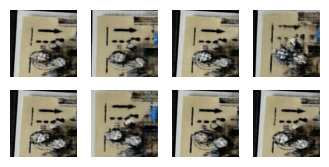

In [22]:
if experiment['TYPE'] == 'train':
    attention_resnet50_autoencoder_model_hist = train(train_dataset, experiment['EPOCHS'])

In [23]:
import shutil

if experiment['TYPE'] == 'train':
  shutil.copy('/content/attention_resnet50_autoencoder_model/BD67_dataset/training_weights/attention_resnet50_autoencoder_model_199.h5', '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/Chekpoints/attention_resnet50_autoencoder_model/experiment_1')

In [24]:
#if experiment['TYPE'] == 'test':
#  attention_resnet50_autoencoder_model.load_weights('/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/Chekpoints/attention_resnet50_autoencoder_model/experiment_1/attention_resnet50_autoencoder_model_199.h5')

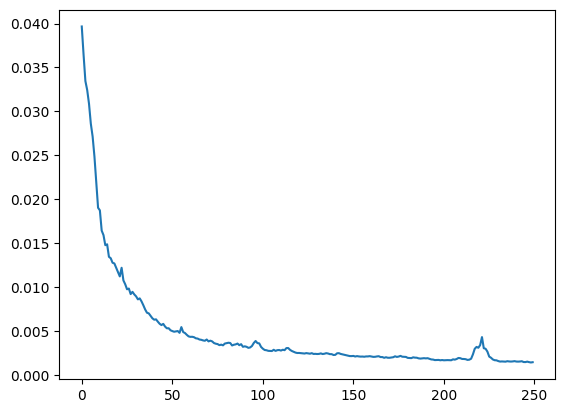

In [25]:
plt.plot(attention_resnet50_autoencoder_model_hist)

In [26]:
def get_generated_image_batch(data):
    reconstructed_batch = None

    for image_batch in data:
      generated_batch = attention_resnet50_autoencoder_model.predict(image_batch)

      if reconstructed_batch is None:
          reconstructed_batch = generated_batch
      else:
          reconstructed_batch = np.concatenate((reconstructed_batch, generated_batch))

      if reconstructed_batch.shape[0] > 5000:
          break

    return reconstructed_batch

In [27]:
generated_train_data = get_generated_image_batch(train_dataset.take(1))  # Use only first batch
generated_train_data.shape

1/1 [==============================] - 2s 2s/step


(16, 256, 256, 3)

In [28]:
def show_generated_images(image_batch):
  fig = plt.figure(figsize=(10, 10))
  for index, image in enumerate(image_batch):
    plt.subplot(4, 4, index + 1)
    plt.imshow(image)
    plt.axis('off')
    if index >= 15:
      break
  plt.show()

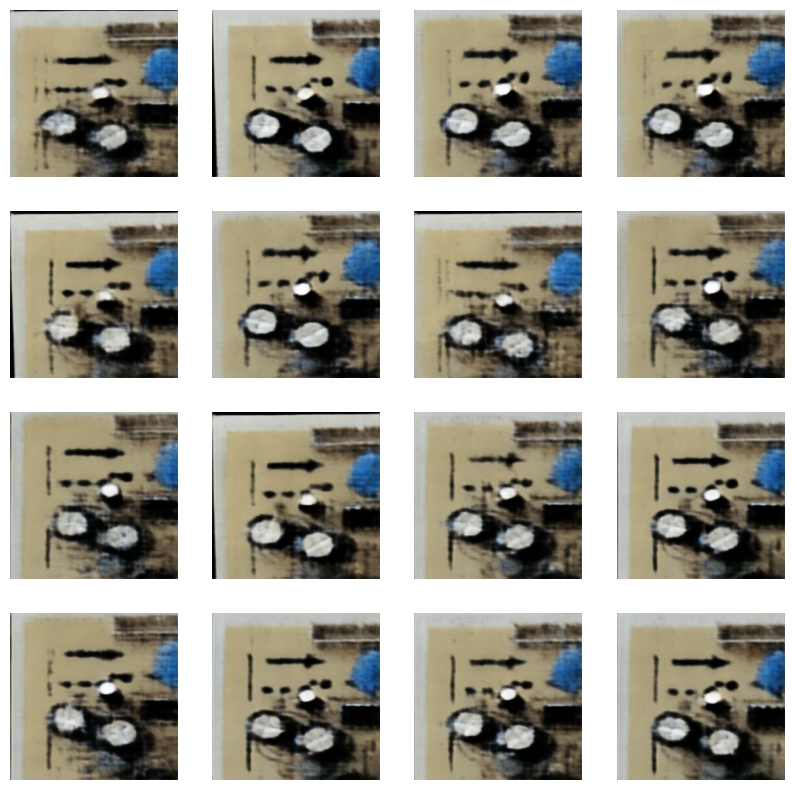

In [29]:
show_generated_images(generated_train_data)

In [30]:
test_img_files = utils.get_image_file_list(BD67_DEFECTED_FRONT_PATH, 'png')

print("Number of Test image files: ", len(test_img_files))

Number of Test image files:  10


In [31]:
test_dataset = utils.create_dataset_pipeline(test_img_files, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0, aug_layer=None, data_aug_power=1, accelerator='GPU')

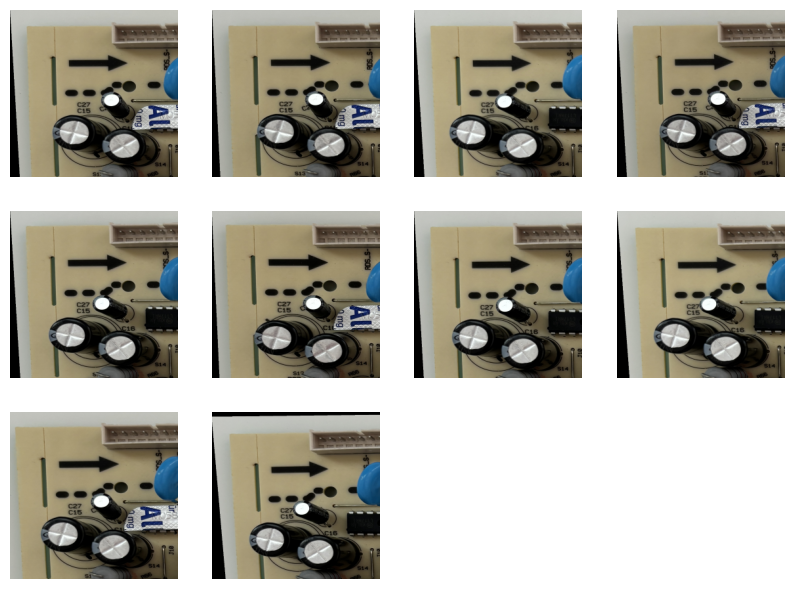

In [32]:
vision.show_image_samples_from_batch(test_dataset)

1/1 [==============================] - 0s 94ms/step


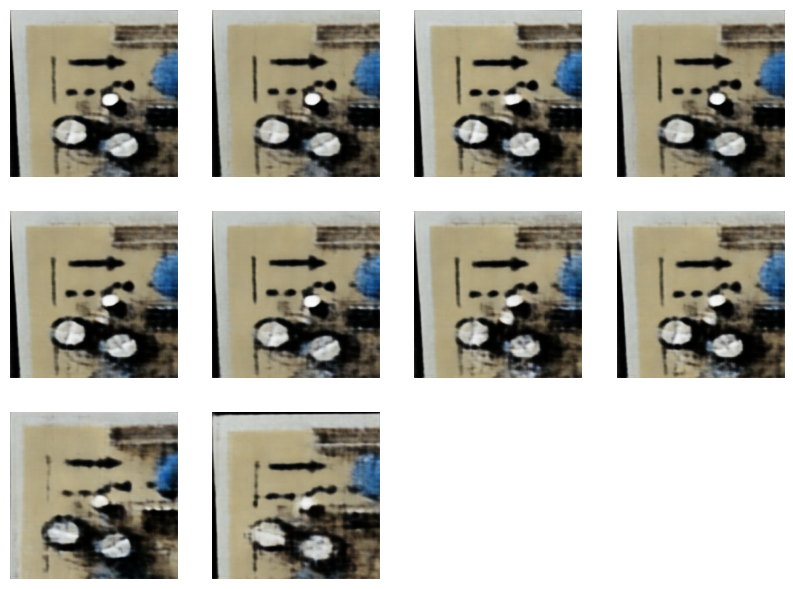

In [33]:
generated_test_data = get_generated_image_batch(test_dataset)

show_generated_images(generated_test_data)

In [34]:
def display_pixel_wise_img_diff(img1_dir, img2_dir, threshold=None, verbose=0, channel=0):
  # Load your two images using TensorFlow
  #image1 = tf.image.decode_image(tf.io.read_file(img1_dir))
  #image2 = tf.image.decode_image(tf.io.read_file(img2_dir))
  image1 = img1_dir
  image2 = img2_dir

  # Ensure both images have the same shape and data type
  image1 = tf.cast(image1, tf.float32)
  image2 = tf.cast(image2, tf.float32)

  # Compute pixel-wise absolute differences
  diff = tf.abs(image1 - image2)
  if verbose > 0:  print(f"Difference map shape: {diff.shape}")

  # Define a colormap (e.g., 'jet') and normalize the differences
  cmap = plt.get_cmap('jet')
  norm = plt.Normalize(vmin=0, vmax=tf.reduce_max(diff).numpy())
  norm_diff = norm(diff)
  if verbose > 0:
    print(f"Normalized difference map shape: {norm_diff.shape}")
    print(f"Normalized difference map min, avg, max value: ({np.min(norm_diff)}, {np.mean(norm_diff):.5f}, {np.max(norm_diff)})")

  colored_diff = cmap(norm_diff)
  if verbose > 0:  print(f"Colored difference map shape: {colored_diff.shape}")

  color_diff_plot = colored_diff[:, :, :,channel]

  if threshold != None:
    color_diff_plot[color_diff_plot < threshold] = 0.0

  # Display the color-coded difference map
  plt.imshow(color_diff_plot)
  plt.colorbar()
  plt.axis('off')
  plt.show()

In [35]:
test_batch = next(iter(test_dataset))

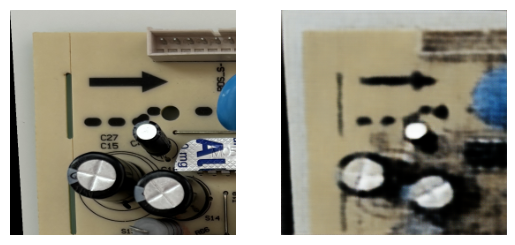

In [36]:
test_ix = 0

plt.subplot(1,2,1)
plt.imshow(test_batch[test_ix])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated_test_data[test_ix])
plt.axis('off')
plt.show()

Difference map shape: (256, 256, 3)
Normalized difference map shape: (256, 256, 3)
Normalized difference map min, avg, max value: (6.076346039662894e-07, 0.08036, 1.0)
Colored difference map shape: (256, 256, 3, 4)


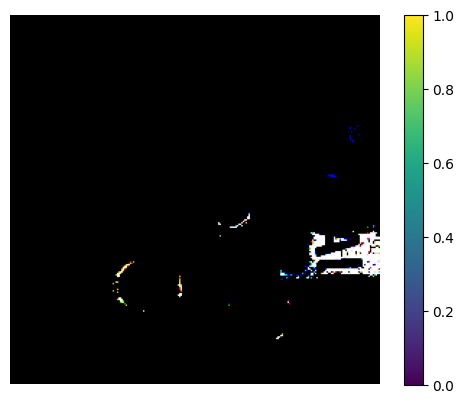

In [38]:
display_pixel_wise_img_diff(test_batch[test_ix], generated_test_data[test_ix], threshold=0.8, channel=0, verbose=1)